# Positive Tone Data Generator

This notebook contains code for an MLP neural network that generates positively toned data based on the dataset. Feature vectors are then made from the positively toned data and generated data then saved into .csv files.

### Import Libraries

In [1]:
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from gensim.models import Word2Vec
from nltk import regexp_tokenize, WordNetLemmatizer
import random

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Input

In [3]:
df_raw = pd.read_csv('poem_sentiment.csv', header=None, index_col=0, names=['Text', 'Sentiment'])
df_raw

,Text,Sentiment
0,with pale blue berries. in these peaceful shad...,1.0
1,it flows so long as falls the rain,0.0
2,"and that is why, the lonesome day",-1.0
3,"when i peruse the conquered fame of heroes, an...",2.0
4,of inward strife for truth and liberty.,2.0
...,...,...
887,to his ears there came a murmur of far seas be...,0.0
888,"the one good man in the world who knows me, --",1.0
889,faint voices lifted shrill with pain,-1.0
890,"an', fust you knowed on, back come charles the...",0.0


In [4]:
positive = df_raw[df_raw['Sentiment'] > 0]
positive

,Text,Sentiment
0,with pale blue berries. in these peaceful shad...,1.0
3,"when i peruse the conquered fame of heroes, an...",2.0
4,of inward strife for truth and liberty.,2.0
5,the red sword sealed their vows!,2.0
16,that has a charmingly bourbon air.,1.0
...,...,...
870,their first-born brother as a god.,1.0
876,and so i should be loved and mourned to-night.,2.0
877,"and _channing_, with his bland, superior look",2.0
884,"how your soft opera-music changed, and the dru...",2.0


### Text Preprocessing

In [5]:
raw_text = positive['Text'].to_string(index=False)
raw_text[:1000]

'with pale blue berries. in these peaceful shades--\nwhen i peruse the conquered fame of heroes, and...\n           of inward strife for truth and liberty.\n                  the red sword sealed their vows!\n                that has a charmingly bourbon air.\n          brightly expressive as the twins of leda\n               in monumental pomp! no grecian drop\n                    the hostile cohorts melt away;\nand lips where heavenly smiles would hang and b...\n                         honour to the bugle-horn!\n                       if the pure and holy angels\n        upon the thought of perfect noon. and when\n      thy hands all cunning arts that women prize.\n             reasoning to admiration, and with mee\n           it shines superior on a throne of gold:\n    take the warm welcome of new friends with thee\n                  augmented, sweet, a hundred fold\n                every day a rich reward will give;\n                                 gay little heart!\n         am

In [6]:
# Remove all non-ASCII characters
processed_text = re.sub(r'[^\x00-\x7f]', r'', raw_text).lower()
processed_text[:1000]

'with pale blue berries. in these peaceful shades--\nwhen i peruse the conquered fame of heroes, and...\n           of inward strife for truth and liberty.\n                  the red sword sealed their vows!\n                that has a charmingly bourbon air.\n          brightly expressive as the twins of leda\n               in monumental pomp! no grecian drop\n                    the hostile cohorts melt away;\nand lips where heavenly smiles would hang and b...\n                         honour to the bugle-horn!\n                       if the pure and holy angels\n        upon the thought of perfect noon. and when\n      thy hands all cunning arts that women prize.\n             reasoning to admiration, and with mee\n           it shines superior on a throne of gold:\n    take the warm welcome of new friends with thee\n                  augmented, sweet, a hundred fold\n                every day a rich reward will give;\n                                 gay little heart!\n         am

### Tokenization

In [7]:
# Get word tokens from text
word_tokens = regexp_tokenize(processed_text, pattern=r'[^\S\r]+|[\.,:;!?()--_"]', gaps=True)
print(f"Number of word tokens: {len(word_tokens)}")
word_tokens[:10]

Number of word tokens: 1292


['with',
 'pale',
 'blue',
 'berries',
 'in',
 'these',
 'peaceful',
 'shades',
 'when',
 'i']

In [8]:
# Lemmatization done to make uncommon words more likely to be recognized by 
# Word2Vec model later when converting to feature vectors
lemmatizer = WordNetLemmatizer()
word_tokens = [lemmatizer.lemmatize(token) for token in word_tokens] # Lemmatize nouns
word_tokens = [lemmatizer.lemmatize(token, 'v') for token in word_tokens] # Lemmatize verbs

In [9]:
# Get unique word tokens from word tokens
unique_words = sorted(list(set(word_tokens)))
print(f"Number of unique word tokens: {len(unique_words)}")

Number of unique word tokens: 628


In [10]:
# Create vocabulary of word tokens
word_vocabulary = unique_words
word_vocabulary[:10]

["'tis",
 'a',
 'abide',
 'abloom',
 'about',
 'accordance',
 'adam',
 'adept',
 'admiration',
 'after']

### Create word-index mappings

In [11]:
# Create index-word mappings 
indices_words = dict((index, word) for index, word in enumerate(unique_words))
indices_words

{0: "'tis",
 1: 'a',
 2: 'abide',
 3: 'abloom',
 4: 'about',
 5: 'accordance',
 6: 'adam',
 7: 'adept',
 8: 'admiration',
 9: 'after',
 10: 'again',
 11: 'ah',
 12: 'air',
 13: 'all',
 14: 'already',
 15: 'amidst',
 16: 'among',
 17: 'an',
 18: 'and',
 19: 'angel',
 20: 'angry',
 21: 'arm',
 22: 'around',
 23: 'art',
 24: 'ascend',
 25: 'ash',
 26: 'aspire',
 27: 'assay',
 28: 'augment',
 29: 'away',
 30: 'awe',
 31: 'ay',
 32: 'b',
 33: 'bare',
 34: 'be',
 35: 'bear',
 36: 'beauteous',
 37: 'beautiful',
 38: 'beauty',
 39: "beauty'",
 40: 'because',
 41: 'before',
 42: 'bell',
 43: 'bend',
 44: 'beneath',
 45: 'berry',
 46: 'best',
 47: 'betray',
 48: 'between',
 49: 'blade',
 50: 'bland',
 51: 'blaze',
 52: 'bless',
 53: 'blind',
 54: 'blue',
 55: 'bolt',
 56: 'borrow',
 57: 'boston',
 58: 'bourbon',
 59: 'bow',
 60: 'brave',
 61: 'braver',
 62: 'breast',
 63: 'bright',
 64: 'brightly',
 65: 'brilliant',
 66: 'brother',
 67: "brynhilda's",
 68: 'bugle',
 69: 'burn',
 70: 'burst',
 71

In [12]:
# Create word-index mappings
word_indices = dict((word, index) for index, word in enumerate(unique_words))
word_indices

{"'tis": 0,
 'a': 1,
 'abide': 2,
 'abloom': 3,
 'about': 4,
 'accordance': 5,
 'adam': 6,
 'adept': 7,
 'admiration': 8,
 'after': 9,
 'again': 10,
 'ah': 11,
 'air': 12,
 'all': 13,
 'already': 14,
 'amidst': 15,
 'among': 16,
 'an': 17,
 'and': 18,
 'angel': 19,
 'angry': 20,
 'arm': 21,
 'around': 22,
 'art': 23,
 'ascend': 24,
 'ash': 25,
 'aspire': 26,
 'assay': 27,
 'augment': 28,
 'away': 29,
 'awe': 30,
 'ay': 31,
 'b': 32,
 'bare': 33,
 'be': 34,
 'bear': 35,
 'beauteous': 36,
 'beautiful': 37,
 'beauty': 38,
 "beauty'": 39,
 'because': 40,
 'before': 41,
 'bell': 42,
 'bend': 43,
 'beneath': 44,
 'berry': 45,
 'best': 46,
 'betray': 47,
 'between': 48,
 'blade': 49,
 'bland': 50,
 'blaze': 51,
 'bless': 52,
 'blind': 53,
 'blue': 54,
 'bolt': 55,
 'borrow': 56,
 'boston': 57,
 'bourbon': 58,
 'bow': 59,
 'brave': 60,
 'braver': 61,
 'breast': 62,
 'bright': 63,
 'brightly': 64,
 'brilliant': 65,
 'brother': 66,
 "brynhilda's": 67,
 'bugle': 68,
 'burn': 69,
 'burst': 70,
 'b

### Create Blocks

In [13]:
# Create x (input): Split text into blocks, where each block has the same amount of words
# Create y (targets): For each x input, the y is the word that comes next
# The model should learn to predict y from the input x

block_size = 2
step = 1

x = []
y = []

for i in range(0, len(word_tokens) - block_size, step):
    x.append(word_tokens[i: i+block_size])
    y.append(word_tokens[i + block_size])

In [14]:
# Inspect x
x[:5]

[['with', 'pale'],
 ['pale', 'blue'],
 ['blue', 'berry'],
 ['berry', 'in'],
 ['in', 'these']]

In [15]:
# Check number of blocks
len(x)

1290

### Create One-Hot Encoding

In [16]:
# Create one-hot encoding of x
x_encoded = []

for x_arr in x:
    x_ints = [word_indices[item] for item in x_arr]
    
    x_row = []
    for item in x_ints:
        x_vector = np.zeros(len(unique_words))
        x_vector[item] = 1
        x_row.append(x_vector)
        
    x_encoded.append(x_row)
    
x_encoded = np.array(x_encoded)

In [17]:
# Inspect y
y[:5]

['blue', 'berry', 'in', 'these', 'peaceful']

In [18]:
# Convert each word in y into their corresponding indices
y_ints = [word_indices[item] for item in y]
y_ints[:5]

[54, 45, 257, 539, 386]

In [19]:
# Create one-hot encoding of y
y_encoded = []

for item in y_ints:
    y_vector = np.zeros(len(unique_words))
    y_vector[item] = 1
    y_encoded.append(y_vector)

y_encoded = np.array(y_encoded)

### Model Configuration

In [20]:
class TextGenerator(nn.Module):
    def __init__(self, input_dim, output_dim, block_size):
        super().__init__()

        self.embeddings = nn.Linear(input_dim, 2000)
        self.hidden = nn.Linear(2000, 1200)
        self.output = nn.Linear(1200, output_dim)
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.sigmoid(self.embeddings(x))
        x = self.tanh(self.hidden(x))
        x = self.softmax(self.output(x))

        return x

In [21]:
# Get size of input for training the model
input_size = x_encoded[0].ravel().shape[0]
print(x_encoded[0].ravel().shape[0])

1256


In [22]:
# Allocate tensors to the device used for computation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Performing torch operations on {device} device")

# Create x and y PyTorch tensors
x = torch.tensor(x_encoded).float().to(device)
y = torch.tensor(y_encoded).float().to(device)

Performing torch operations on cpu device


In [23]:
# Instantiate model
model = TextGenerator(input_size, len(unique_words), block_size).to(device)

# Print model configuration
model

TextGenerator(
  (embeddings): Linear(in_features=1256, out_features=2000, bias=True)
  (hidden): Linear(in_features=2000, out_features=1200, bias=True)
  (output): Linear(in_features=1200, out_features=628, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

In [24]:
# Define model optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.000000001)
criterion = nn.CrossEntropyLoss()

### Create Dataset & DataLoader

In [25]:
# Create custom Dataset class
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        self.n_samples = len(x)
    
    def __getitem__(self, index):
        return self.x[index].ravel(), self.y[index]
    
    def __len__(self):
        return self.n_samples

In [26]:
# Create training dataset using custom Dataset class
training_ds = CustomDataset(x, y)

In [27]:
# Load training dataset into DataLoader
from torch.utils.data import DataLoader

batch_size = 10

train_loader = DataLoader(
    training_ds,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

### Train Model

In [28]:
# Define function to train model
def train_fn(loader, model, optimizer, loss_fn, device):
    loop = tqdm(loader)

    ave_loss = 0
    count = 0 
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Forward
        predictions = model.forward(data)
        loss = loss_fn(predictions, targets)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update tqdm loading bar
        loop.set_postfix(loss=loss.item())

        count += 1
        ave_loss += loss.item()
    
    ave_loss = ave_loss / count

    return ave_loss

In [29]:
# Train model
epochs = 2 # TODO: CHANGE TO 300 ON FINAL DATA; CURRENTLY 2 FOR TESTING PURPOSES
average_losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    ave_loss = train_fn(train_loader, model, optimizer, criterion, device)
    
    print("Ave Loss: {}".format(ave_loss))
    average_losses.append(ave_loss)

Epoch: 0


100%|█████████████████████████████████████████████████████████████████████| 129/129 [00:08<00:00, 15.53it/s, loss=6.44]


Ave Loss: 6.442534084467924
Epoch: 1


100%|█████████████████████████████████████████████████████████████████████| 129/129 [00:08<00:00, 14.76it/s, loss=6.44]

Ave Loss: 6.442533999450447


### Generate Text

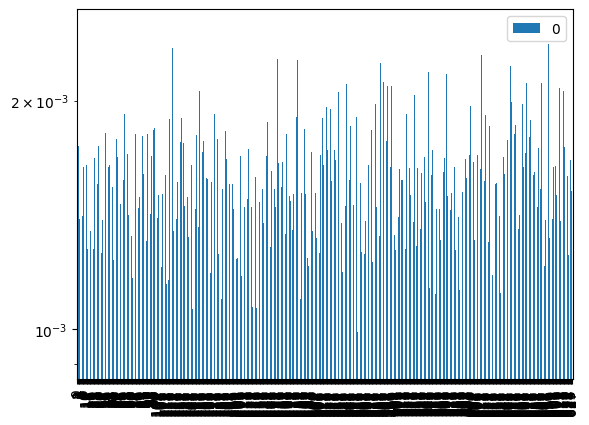

In [30]:
# Inspect probability distribution of word tokens
import matplotlib.pyplot as plt
import pandas as pd
random.seed(2)

phrase = [indices_words[random.randint(0, len(unique_words))], indices_words[random.randint(0, len(unique_words))]]
x_ints = [word_indices[item] for item in phrase]
x_vector = []

for item in x_ints:
    x_item = np.zeros(len(unique_words))
    x_item[item] = 1
    x_vector.append(x_item)

initial_input = torch.tensor([np.array([x_vector]).ravel()]).to(dtype=torch.float32)
output = model(initial_input)[0].detach().cpu().numpy()

df = pd.DataFrame(output)
df.plot.bar()
plt.yscale("log")
plt.show()

In [31]:
# Generate text sample from model output
word_count = 100
text = []
paragraph_count = 5

# Length of phrase should be same as block_size
word1, word2 = indices_words[random.randint(0, len(unique_words))], indices_words[random.randint(0, len(unique_words))]

for p in range(paragraph_count):
    text.append([])
    
    for i in range(word_count):
        phrase = [word1, word2]
        x_ints = [word_indices[item] for item in phrase]
        x_vector = []

        for item in x_ints:
            x_item = np.zeros(len(unique_words))
            x_item[item] = 1
            x_vector.append(x_item)

        initial_input = torch.tensor([np.array([x_vector]).ravel()]).float().to(device)

        output = model(initial_input)[0].detach().cpu().numpy()

        # Workaround to fix occasional sum(pvals[:-1]) > 1.0  bug from implicit casting in np.random.multinomial 
        output = output.astype(float)
        output /= output.sum()

        index = np.where(np.random.multinomial(1, output) == 1)[0][0]
        word3 = indices_words[index]
        text[p].append(word3)

        # Use generated word from this run as seed for next run
        word1, word2 = word2, word3

In [32]:
for p in range(paragraph_count):
    print(f"Generated Paragraph {p}:")
    print(' '.join(text[p]))
    print('\n')

Generated Paragraph 0:
turn strike virtue's thee dear seat stir prize goodness felt perfect me climax simpler upon throw pen cabinet because mightily give fear mightily sing seal hundred merit abloom nature a after delicious war doth here war glorious blaze shall past throug snow hue fearless reason cunning declare hundred war stately blade chariot miscall away strife mind dead despise war martineau corpse play spirit welcome adam ocean quoth vast first mine sun they mine flame despise take stept bless wrath duty quoth myriad kiss mother shade onaway doth seven rapture calm light holy million please summer's world admiration pure no weary


Generated Paragraph 1:
fell air brother give moses plume before face prayer bourbon adam please golden light sincerest playmates' her about warm youth's hundred accordance nobler call bow should praise costume play gudrun rich own friend every till fond de good folk heart image would lure plume past wouldst wonder music look sea fair grace sharpness

### Create Feature Vectors from Input Data

In [33]:
sentences = []

# Tokenize by line
for index, row in positive.iterrows():
    tokenized_row = row['Text'].split(' ')
      
    # Preprocess using the same settings as preprocessing done before training model
    tokenized_row = regexp_tokenize(' '.join(tokenized_row), pattern=r'[^\S\r\n]+|[\.,;!?()--_"]', gaps=True)
    tokenized_row = [lemmatizer.lemmatize(token) for token in tokenized_row] # Lemmatize nouns
    tokenized_row = [lemmatizer.lemmatize(token, 'v') for token in tokenized_row] # Lemmatize verbs
    
    sentences.append(tokenized_row)
    
sentences

[['with', 'pale', 'blue', 'berry', 'in', 'these', 'peaceful', 'shade'],
 ['when',
  'i',
  'peruse',
  'the',
  'conquer',
  'fame',
  'of',
  'hero',
  'and',
  'the',
  'victory',
  'of',
  'mighty',
  'general',
  'i',
  'do',
  'not',
  'envy',
  'the',
  'general'],
 ['of', 'inward', 'strife', 'for', 'truth', 'and', 'liberty'],
 ['the', 'red', 'sword', 'seal', 'their', 'vow'],
 ['that', 'ha', 'a', 'charmingly', 'bourbon', 'air'],
 ['brightly', 'expressive', 'a', 'the', 'twin', 'of', 'leda'],
 ['in', 'monumental', 'pomp', 'no', 'grecian', 'drop'],
 ['the', 'hostile', 'cohort', 'melt', 'away'],
 ['and', 'lip', 'where', 'heavenly', 'smile', 'would', 'hang', 'and', 'blend'],
 ['honour', 'to', 'the', 'bugle', 'horn'],
 ['if', 'the', 'pure', 'and', 'holy', 'angel'],
 ['upon', 'the', 'think', 'of', 'perfect', 'noon', 'and', 'when'],
 ['thy', 'hand', 'all', 'cunning', 'art', 'that', 'woman', 'prize'],
 ['reason', 'to', 'admiration', 'and', 'with', 'mee'],
 ['it', 'shine', 'superior', 'on'

In [34]:
vector_size = 100
w2v_model = Word2Vec(sentences, vector_size=vector_size, min_count=1)

In [35]:
vocab = w2v_model.wv.index_to_key
vocab_length = len(vocab)

print(f'Vocabulary Size: {format(vocab_length)}')

Vocabulary Size: 653


In [36]:
vocab

['the',
 'and',
 'of',
 'a',
 'in',
 'to',
 'be',
 'with',
 'her',
 'that',
 'his',
 'i',
 'thy',
 'love',
 'heart',
 'on',
 'their',
 'from',
 'sweet',
 'wa',
 'our',
 'so',
 'thou',
 'all',
 'me',
 'by',
 'day',
 'this',
 'it',
 'but',
 'hope',
 'my',
 'through',
 'your',
 'when',
 'delight',
 'bright',
 'than',
 'thee',
 'you',
 'soft',
 'for',
 'lip',
 'king',
 'how',
 'like',
 'those',
 'full',
 'he',
 'would',
 'do',
 'think',
 'death',
 'have',
 'heaven',
 'art',
 'soul',
 'she',
 'bless',
 'whose',
 'peace',
 'star',
 'who',
 'mine',
 'we',
 'hand',
 'look',
 'friend',
 'war',
 'swifter',
 'far',
 'kiss',
 'tender',
 'man',
 'rich',
 'truth',
 'give',
 'right',
 'happy',
 'brave',
 'god',
 'eye',
 'smile',
 'shin',
 'run',
 'calm',
 'song',
 'first',
 'u',
 'thus',
 'head',
 'fame',
 'bend',
 'even',
 'bell',
 'live',
 'hero',
 'mighty',
 'between',
 'night',
 'around',
 'past',
 'uppe',
 'out',
 'tranquil',
 'awe',
 'or',
 'play',
 'slumber',
 'light',
 'glow',
 'life',
 'nor'

In [37]:
w2v_model.wv.similarity('i', 'me')

0.030011235

In [38]:
def sentence_to_vector_averaging(sentence, model):
    embeddings = [model.wv[word] for word in sentence if word in vocab]
    
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(embeddings, axis=0)

In [39]:
features = []

for sentence in sentences:
    features.append(sentence_to_vector_averaging(sentence, w2v_model))

In [40]:
columns = [f'x{i}' for i in range(w2v_model.vector_size)]

df_text = pd.DataFrame(features, columns=columns)

In [41]:
df_text['y'] = [float(x) for x in positive['Sentiment']]
df_text

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,0.000539,-0.002841,0.001038,0.001227,0.001702,-0.000181,-0.000825,0.001076,-0.003619,0.001606,...,-0.002670,0.001494,0.000342,0.001086,-0.002365,-0.000088,0.001719,0.000227,0.002161,1.0
1,0.000121,0.001598,-0.002022,0.003518,-0.000634,-0.002769,-0.000015,0.004520,-0.003272,-0.001034,...,0.001636,0.000892,-0.001251,0.005686,0.001471,-0.000284,-0.003353,-0.000166,0.000829,2.0
2,-0.002452,0.002751,-0.001009,-0.002248,0.006385,-0.002959,0.003530,0.001689,-0.001781,-0.000203,...,-0.001953,0.001702,-0.004471,-0.001321,0.002298,0.002728,-0.002785,0.000267,0.000292,2.0
3,-0.003758,0.000238,0.001691,0.002436,-0.001121,-0.004381,0.002311,0.002936,-0.003526,-0.001478,...,0.002834,-0.001215,0.001329,-0.000051,0.000017,-0.000712,0.000364,-0.000582,0.004109,2.0
4,-0.003734,0.001693,0.000943,-0.000015,0.003691,-0.002938,-0.001058,0.002985,-0.002023,0.000893,...,-0.001639,-0.002646,-0.001628,0.002200,0.001421,-0.002657,0.000847,0.001100,-0.002147,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,-0.003591,0.003996,-0.000980,-0.002697,0.004371,0.000471,-0.002946,0.006642,0.001454,-0.002446,...,0.001031,0.000373,0.003400,0.002116,0.002087,-0.000821,-0.005468,-0.005244,0.000961,1.0
178,-0.002167,0.004227,0.001152,0.001860,-0.002613,-0.001653,0.000696,0.001916,-0.002462,-0.002285,...,-0.000142,-0.000851,-0.001571,-0.000798,0.000395,0.001990,-0.002791,-0.002992,0.001213,2.0
179,0.001723,0.002398,0.004649,0.000669,-0.000637,-0.005126,-0.002016,0.002498,-0.003543,-0.004117,...,0.000347,0.000257,0.002380,0.002526,-0.000808,0.005200,-0.002791,0.003074,-0.001275,2.0
180,-0.001747,-0.000523,0.000780,0.000870,0.001192,-0.002961,0.001725,0.003217,0.000461,-0.003474,...,-0.000077,0.002848,-0.000993,-0.000057,0.000451,-0.000989,-0.002585,-0.001034,0.002086,2.0


In [42]:
# Save feature vectors as csv
df_text.to_csv('positive.csv')

### Create Feature Vectors from Generated Data

In [43]:
vector_size = 100
w2v_model = Word2Vec(text, vector_size=vector_size, min_count=1)

In [44]:
vocab = w2v_model.wv.index_to_key
vocab_length = len(vocab)

print(f'Vocabulary Size: {format(vocab_length)}')

Vocabulary Size: 347


In [45]:
vocab

['gudrun',
 'commend',
 'despise',
 'hundred',
 'calm',
 'please',
 'war',
 'fear',
 'sun',
 'adam',
 'welcome',
 'play',
 'reason',
 'past',
 'doth',
 'nature',
 'quoth',
 'peruse',
 'face',
 'jet',
 'hope',
 'look',
 'fair',
 'john',
 'pulse',
 'robe',
 'foot',
 'just',
 'thereupon',
 'fairer',
 "pleas'd",
 'old',
 'ere',
 'china',
 'memory',
 'rhyme',
 'grave',
 'shore',
 'outshine',
 'bland',
 'president',
 'laugh',
 'may',
 'mourn',
 'bright',
 'worthy',
 'charmingly',
 'faster',
 'slumber',
 'circle',
 'science',
 'nor',
 'worth',
 'goal',
 'estrange',
 'joyous',
 'good',
 'wonder',
 'golden',
 'de',
 'miscall',
 'cunning',
 'fearless',
 'hue',
 'snow',
 'abloom',
 'seal',
 'give',
 'mightily',
 'cabinet',
 'throw',
 'climax',
 'me',
 'perfect',
 'felt',
 'seat',
 'dear',
 'strike',
 'chariot',
 'mind',
 'rich',
 'corpse',
 'bow',
 'call',
 'nobler',
 "youth's",
 'sincerest',
 'ay',
 'bourbon',
 'plume',
 'moses',
 'pure',
 'world',
 "summer's",
 'million',
 'light',
 'myriad',
 

In [46]:
vectors = [w2v_model.wv[word] for word in vocab]
len(vectors[0])

100

In [47]:
def sentence_to_vector_averaging(sentence, model):
    embeddings = [model.wv[word] for word in sentence if word in vocab]
    
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(embeddings, axis=0)

In [48]:
features = []

for sentence in text:
    features.append(sentence_to_vector_averaging(sentence, w2v_model))

In [49]:
columns = [f'x{i}' for i in range(w2v_model.vector_size)]

df_text = pd.DataFrame(features, columns=columns)

In [50]:
df_text['y'] = [1] * len(df_text)
df_text

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,-0.000509,0.000337,-0.000608,-0.000633,0.000250,-0.001153,0.000305,0.001490,-0.000184,0.000172,...,0.000620,-0.000026,-0.000127,0.001553,0.000383,0.001907,-0.000794,0.000342,-0.000957,1
1,-0.000052,0.000775,-0.000553,0.000436,-0.000130,-0.000639,0.000847,0.000822,-0.000477,0.000715,...,0.000706,-0.000861,-0.000466,0.000140,-0.000533,-0.000764,-0.001775,0.000730,0.000135,1
2,0.000049,0.000798,0.000230,-0.000865,0.000165,-0.000787,-0.000218,0.000608,0.000311,-0.000463,...,-0.000409,-0.000659,0.000165,-0.000951,0.000816,0.000016,0.000937,-0.000303,-0.000284,1
3,0.000325,0.000154,0.000173,0.000586,0.000772,0.000459,0.000975,0.001213,-0.001368,-0.000161,...,0.000446,0.000400,0.001124,0.000730,0.001496,0.000137,-0.000946,0.000955,-0.000096,1
4,-0.000491,-0.000259,0.001148,0.000823,0.000151,-0.000897,0.000303,0.000661,-0.000062,-0.001459,...,0.000877,0.000559,-0.000450,0.001388,0.000526,-0.000162,-0.000023,0.000223,0.000697,1


In [51]:
# Save feature vectors as csv
df_text.to_csv('positive_generated.csv')